In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [99]:
dados = pd.read_csv("data/ca-NE-unido.csv")

In [100]:

# Mostra o nome das colunas
print("Nomes das colunas:")
print(dados.columns)

Nomes das colunas:
Index(['Regiao - Sigla', 'Estado - Sigla', 'Municipio', 'Revenda',
       'CNPJ da Revenda', 'Nome da Rua', 'Numero Rua', 'Complemento', 'Bairro',
       'Cep', 'Produto', 'Data da Coleta', 'Valor de Venda', 'Valor de Compra',
       'Unidade de Medida', 'Bandeira'],
      dtype='object')


In [101]:
# Verificando quais colunas contêm valores nulos
colunas_nulas = dados.isnull().sum()

# Filtrando para mostrar apenas as colunas que têm valores nulos
colunas_com_nulos = colunas_nulas[colunas_nulas > 0]

print("Colunas com valores nulos:")
print(colunas_com_nulos)

Colunas com valores nulos:
Numero Rua            252
Complemento        248206
Bairro                445
Valor de Compra    354852
dtype: int64


## Pre-Processamento

In [102]:
dados['Data da Coleta'] = pd.to_datetime(dados['Data da Coleta'], format='%d/%m/%Y')
dados['Valor de Venda'] = dados['Valor de Venda'].str.replace(',', '.', regex=False).astype(float)
dados = dados[dados['Produto'] == 'GASOLINA']

dados.set_index('Data da Coleta', inplace=True)

dados['Ano'] = dados.index.year.astype(float)

dados['Mes'] = dados.index.month.astype(float)

dados = dados.drop(columns=['Valor de Compra'])
dados = dados.drop(columns=['Numero Rua'])
dados = dados.drop(columns=['Complemento'])
dados = dados.drop(columns=['CNPJ da Revenda'])


dados_semanal = dados['Valor de Venda'].resample('W').mean()

print(len(dados))

89017


In [103]:
dados.dtypes

Regiao - Sigla        object
Estado - Sigla        object
Municipio             object
Revenda               object
Nome da Rua           object
Bairro                object
Cep                   object
Produto               object
Valor de Venda       float64
Unidade de Medida     object
Bandeira              object
Ano                  float64
Mes                  float64
dtype: object

## Análise de Autocorrelação

<function matplotlib.pyplot.show(close=None, block=None)>

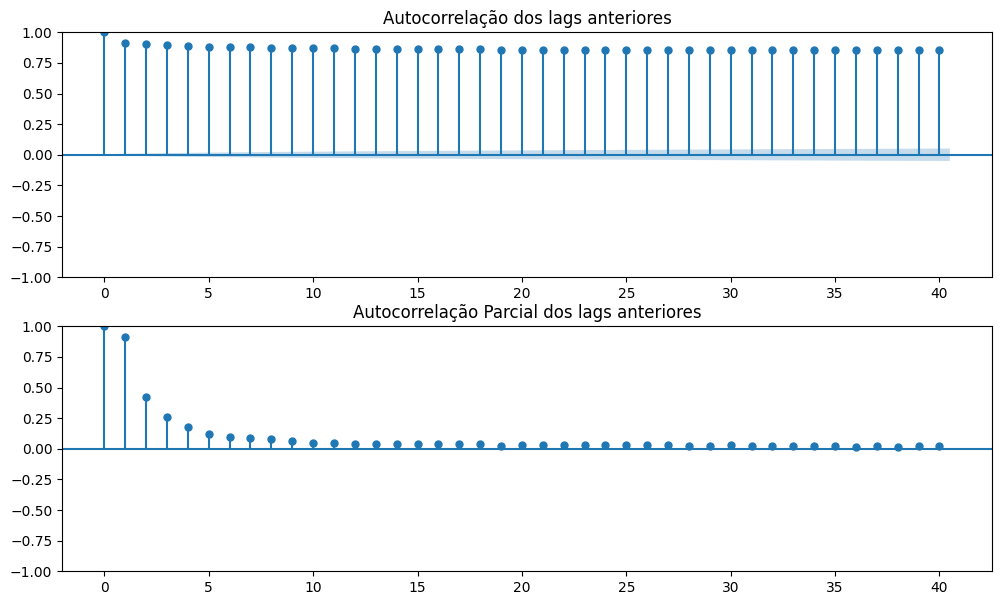

In [104]:
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(211)
fig = plot_acf(dados['Valor de Venda'], lags=40, ax=ax1)
ax1.set_title("Autocorrelação dos lags anteriores")

ax2 = fig.add_subplot(212)
fig = plot_pacf(dados['Valor de Venda'], lags=40, ax=ax2)
ax2.set_title("Autocorrelação Parcial dos lags anteriores")
plt.show

Lags Significantes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


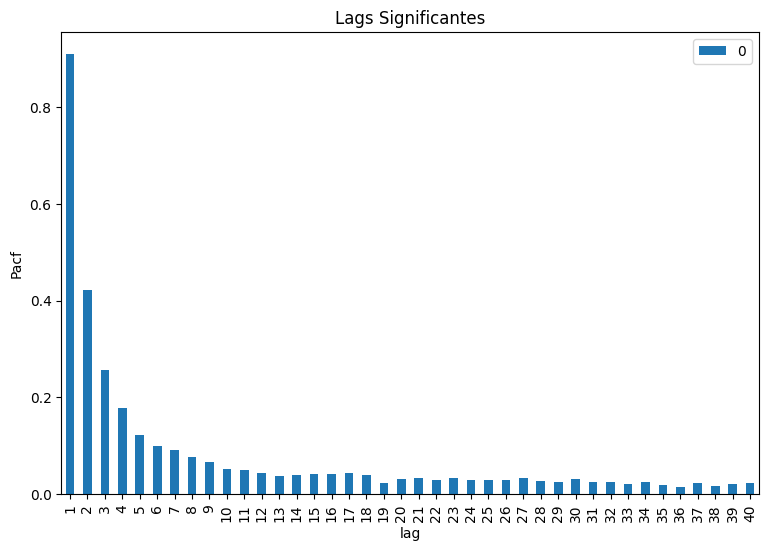

In [105]:
from statsmodels.tsa.stattools import pacf

def getSignificantLags(y, nLags = 5, alpha=0.05):
    Pacf, Pacf_intervalos =  pacf(x=y, nlags=nLags, alpha=alpha)
    pd.DataFrame(Pacf)[1:].plot(kind='bar', figsize=(9,6), legend='pacf valores',
                               xlabel='lag', ylabel='Pacf');
    significantLags = []
    for i in range(1, len(Pacf)):
        # print(pac[i], pac_ci[i][0], pac_ci[i][1])
        if Pacf[i] < Pacf_intervalos[i][0] - Pacf[i] or Pacf[i] > Pacf_intervalos[i][1] - Pacf[i]:
            significantLags.append(i)
    print('Lags Significantes:', significantLags)
    return significantLags

e1_significantLags = getSignificantLags(dados['Valor de Venda'], nLags = 40, alpha=0.05)
plt.title("Lags Significantes")
plt.show()

## Tranformação dos Dados

In [106]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline



from sklearn.model_selection import train_test_split

# Definindo colunas categóricas e numéricas
categorical_features = ['Estado - Sigla', 'Municipio', 'Bandeira']
numeric_features = ['Ano', 'Mes']

# Separando as features e o target
X = dados[categorical_features + numeric_features]
y = dados['Valor de Venda']


# Salvando os índices originais
indices_originais = X.index

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Normalização das features numéricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # OneHotEncoding das features categóricas
    ])

# Criando o pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Aplicando o pipeline aos dados
X_transformed = pipeline.fit_transform(X)

# Convertendo a matriz esparsa para DataFrame, preservando os índices
X_transformed_df = pd.DataFrame(X_transformed.toarray(), 
                                columns=pipeline.named_steps['preprocessor'].get_feature_names_out(),
                                index=indices_originais)

# Dividindo os dados em conjuntos de treino e teste, preservando os índices
X_train, X_test, y_train, y_test = train_test_split(X_transformed_df, y, test_size=0.33, random_state=42, shuffle=False)

# Verificando se os índices são preservados
print(X_train.index[:5])
print(y_train.index[:5])



DatetimeIndex(['2022-01-03', '2022-01-03', '2022-01-03', '2022-01-03',
               '2022-01-03'],
              dtype='datetime64[ns]', name='Data da Coleta', freq=None)
DatetimeIndex(['2022-01-03', '2022-01-03', '2022-01-03', '2022-01-03',
               '2022-01-03'],
              dtype='datetime64[ns]', name='Data da Coleta', freq=None)


## Modelagem

In [107]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Inicializando o modelo
reg = DecisionTreeRegressor()

# Treinando o modelo
reg.fit(X_train, y_train.values.ravel())  # Convertendo y_train para um array 1D

# Fazendo previsões
predicao = reg.predict(X_test)

# Garantindo que y_test seja uma Series e não um DataFrame
y_test_series = y_test.values.ravel()  # Convertendo y_test para um array 1D

# Calculando a diferença entre os valores reais e previstos
diferenca = mean_squared_error(y_test_series, predicao)

# Se você precisar imprimir ou fazer algo com a diferença
print(f"MSE (Mean Squared Error): {diferenca}")


MSE (Mean Squared Error): 0.3943457463160178


In [108]:
# Fazendo previsões
predicao = reg.predict(X_test)

# Garantindo que y_test seja uma Series 1D
y_test_series = y_test.values.ravel()

# Criando um DataFrame com valores reais e previstos, mantendo os índices
df_comparacao = pd.DataFrame({
    'Valor Real': y_test_series,
    'Valor Previsto': predicao
}, index=y_test.index)

# Mostrando o DataFrame
display(df_comparacao)


,Valor Real,Valor Previsto
Data da Coleta,,
2023-05-24,5.62,5.716667
2023-05-24,5.62,5.716667
2023-05-24,5.62,5.723333
2023-05-24,5.69,5.627143
2023-05-24,5.69,5.627143
...,...,...
2023-12-27,5.09,5.032857
2023-12-25,6.09,5.124545
2023-12-26,4.89,4.714000


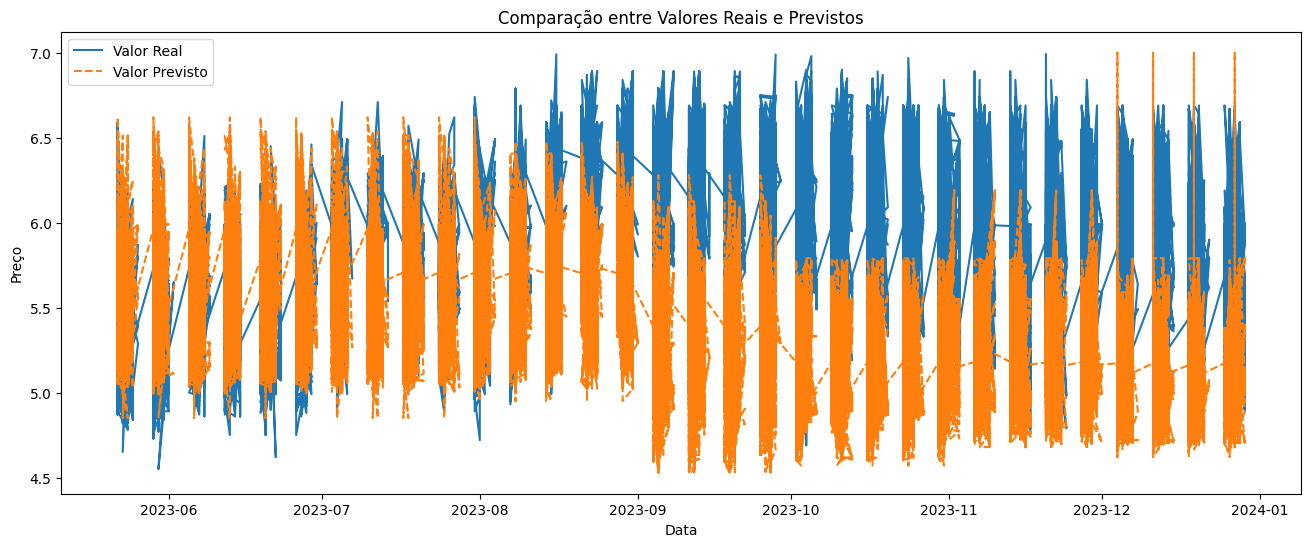

In [109]:
# Plotando os resultados
plt.figure(figsize=(16, 6))
plt.plot(df_comparacao['Valor Real'], label='Valor Real')
plt.plot(df_comparacao['Valor Previsto'], label='Valor Previsto', linestyle='--')
plt.title('Comparação entre Valores Reais e Previstos')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()
